As a stepping stone between SATLAS and SATLAS2, an interface has been provided which can mostly be used as a drop-in replacement for code that uses the SATLAS syntax. Note that not all functionalities have been implemented in this fashion. For users that require these functionalities, we recommend migrating to SATLAS2.

In [1]:
import sys
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '..\src')

import satlas2
import satlas as sat


def modifiedSqrt(input):
    output = np.sqrt(input)
    output[input <= 0] = 1e-3
    return output

# Fitting a single hyperfine spectrum

The most common task, and the one this interface is meant for, is fitting a single hyperfine spectrum. A special class in SATLAS2 called *HFSModel* has been created as a replacement for the equivalent SATLAS *HFSModel*. Note that the normal hyperfine spectrum model in SATLAS2 is called *HFS*.

In [2]:
spin = 3.5
J = [0.5, 1.5]
A = [9600, 175]
B = [0, 315]
C = [0, 0]
FWHMG = 135
FWHML = 101
centroid = 480
bkg = [100]
scale = 90

x = np.arange(-17500, -14500, 40)
x = np.hstack([x, np.arange(20000, 23000, 40)])

rng = np.random.default_rng(0)
hfs = satlas2.HFSModel(I=spin,
                       J=J,
                       ABC=[A[0], A[1], B[0], B[1], C[0], C[1]],
                       centroid=centroid,
                       fwhm=[FWHMG, FWHML],
                       scale=scale,
                       background_params=bkg,
                       use_racah=True)
hfs.set_variation({'Cu': False})

C:\Users\megat\Documents\git_repositories\personal\satlas2\examples\..\src\satlas2\models\hfsModel.py:284: RuntimeWarning: invalid value encountered in scalar divide
  shift = phase * n / d


The object called *hfs* can be used with the syntax of SATLAS. Generating Poisson-distributed data is done by simply calling the function with frequency values as an argument, and using the result for the NumPy Poisson random number generator.

In [3]:
y = hfs(x)
y = rng.poisson(y)

In order to demonstrate the difference in performance, the centroid is offset by 100 from the actual value and the fitting is done by both the interface and SATLAS.

In [4]:
hfs.params['centroid'].value = centroid - 100
# Normal SATLAS implementation
hfs1 = sat.HFSModel(spin,
                    J, [A[0], A[1], B[0], B[1], C[0], C[1]],
                    centroid - 100, [FWHMG, FWHML],
                    scale=scale,
                    background_params=bkg,
                    use_racah=True)
hfs1.set_variation({'Cu': False})

# Interface fitting
print('Fitting 1 dataset with chisquare (Pearson, satlas2)...')
start = time.time()
satlas2.chisquare_fit(hfs, x, y, modifiedSqrt(y))
hfs.display_chisquare_fit(show_correl=False)
stop = time.time()
dt1 = stop - start

# SATLAS fitting
print('Fitting 1 dataset with chisquare (Pearson, satlas)...')
start = time.time()
sat.chisquare_fit(hfs1, x, y, modifiedSqrt(y))
hfs1.display_chisquare_fit(show_correl=False, scaled=True)
stop = time.time()
dt2 = stop - start
print('SATLAS2: {:.3} s'.format(dt1))
print('SATLAS1: {:.3} s'.format(dt2))

C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\satlas\models\hfsmodel.py:573: RuntimeWarning: invalid value encountered in divide
  D = (3*C*(C+1) - 4*I*(I+1)*J*(J+1)) / (2*I*(2*I-1)*J*(2*J-1))
C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\satlas\models\hfsmodel.py:574: RuntimeWarning: invalid value encountered in divide
  E = (10*(0.5*C)**3 + 20*(0.5*C)**2 + C*(-3*I*(I+1)*J*(J+1) + I*(I+1) + J*(J+1) + 3) - 5*I*(I+1)*J*(J+1)) / (I*(I-1)*(2*I-1)*J*(J-1)*(2*J-1))


Fitting 1 dataset with chisquare (Pearson, satlas2)...
define whether you want to see the correlations in display_chisquare_fit(...)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 150
    # variables        = 8
    chi-square         = 151.188938
    reduced chi-square = 1.06471083
    Akaike info crit   = 17.1842512
    Bayesian info crit = 41.2693335
[[Variables]]
    Fit___HFModel__3_5___centroid:  482.548153 +/- 7.56664273 (1.57%) (init = 380)
    Fit___HFModel__3_5___Al:        9604.53248 +/- 6.41301473 (0.07%) (init = 9600)
    Fit___HFModel__3_5___Au:        176.460908 +/- 2.73509313 (1.55%) (init = 175)
    Fit___HFModel__3_5___Bl:        0 (fixed)
    Fit___HFModel__3_5___Bu:        348.564601 +/- 19.6945247 (5.65%) (init = 315)
    Fit___HFModel__3_5___Cl:        0 (fixed)
    Fit___HFModel__3_5___Cu:        0 (fixed)
    Fit___HFModel__3_5___FWHMG:     142.382561 +/- 57.6647446 (40.50%) (init = 135)
    Fit___HFModel

Chisquare fitting done: 172it [00:00, 200.00it/s]                            


NDoF: 142, Chisquare: 151.18894, Reduced Chisquare: 1.0647108
Akaike Information Criterium: 17.18425, Bayesian Information Criterium: 41.269333
Errors scaled with reduced chisquare.


C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\lmfit\printfuncs.py:177: RuntimeWarning: invalid value encountered in scalar divide
  spercent = f'({abs(par.stderr/par.value):.2%})'


[[Variables]]
    FWHMG:        142.398641 +/- 57.6603206 (40.49%) (init = 142.3867)
    FWHML:        100.507637 +/- 63.5294141 (63.21%) (init = 100.519)
    TotalFWHM:    203.616071 +/- 21.3016980 (10.46%) == '0.5346*FWHML+(0.2166*FWHML**2+FWHMG**2)**0.5'
    Scale:        89.2388854 +/- 7.15309431 (8.02%) (init = 89.23958)
    Saturation:   0 (fixed)
    Amp3__2:      0.4546399 (fixed)
    Amp3__3:      0.4773649 (fixed)
    Amp3__4:      0.3410048 (fixed)
    Amp4__3:      0.1591578 (fixed)
    Amp4__4:      0.4773975 (fixed)
    Amp4__5:      1 (fixed)
    Al:           9604.53225 +/- 6.41310259 (0.07%) (init = 9604.532)
    Au:           176.461706 +/- 2.73513458 (1.55%) (init = 176.4611)
    Bl:           0 (fixed)
    Bu:           348.556407 +/- 19.6948460 (5.65%) (init = 348.5624)
    Cl:           0 (fixed)
    Cu:           0 (fixed)
    Centroid:     482.545220 +/- 7.56678472 (1.57%) (init = 482.5474)
    Background0:  100.670920 +/- 1.59296491 (1.58%) (init = 100.6708)
  

Note that the results are functionally identical: the slight difference is due to a more modern implementation of the least squares fitting routine that is used under the hood by SATLAS2. The speedup by using SATLAS 2 is about a factor 20 for a single spectrum.

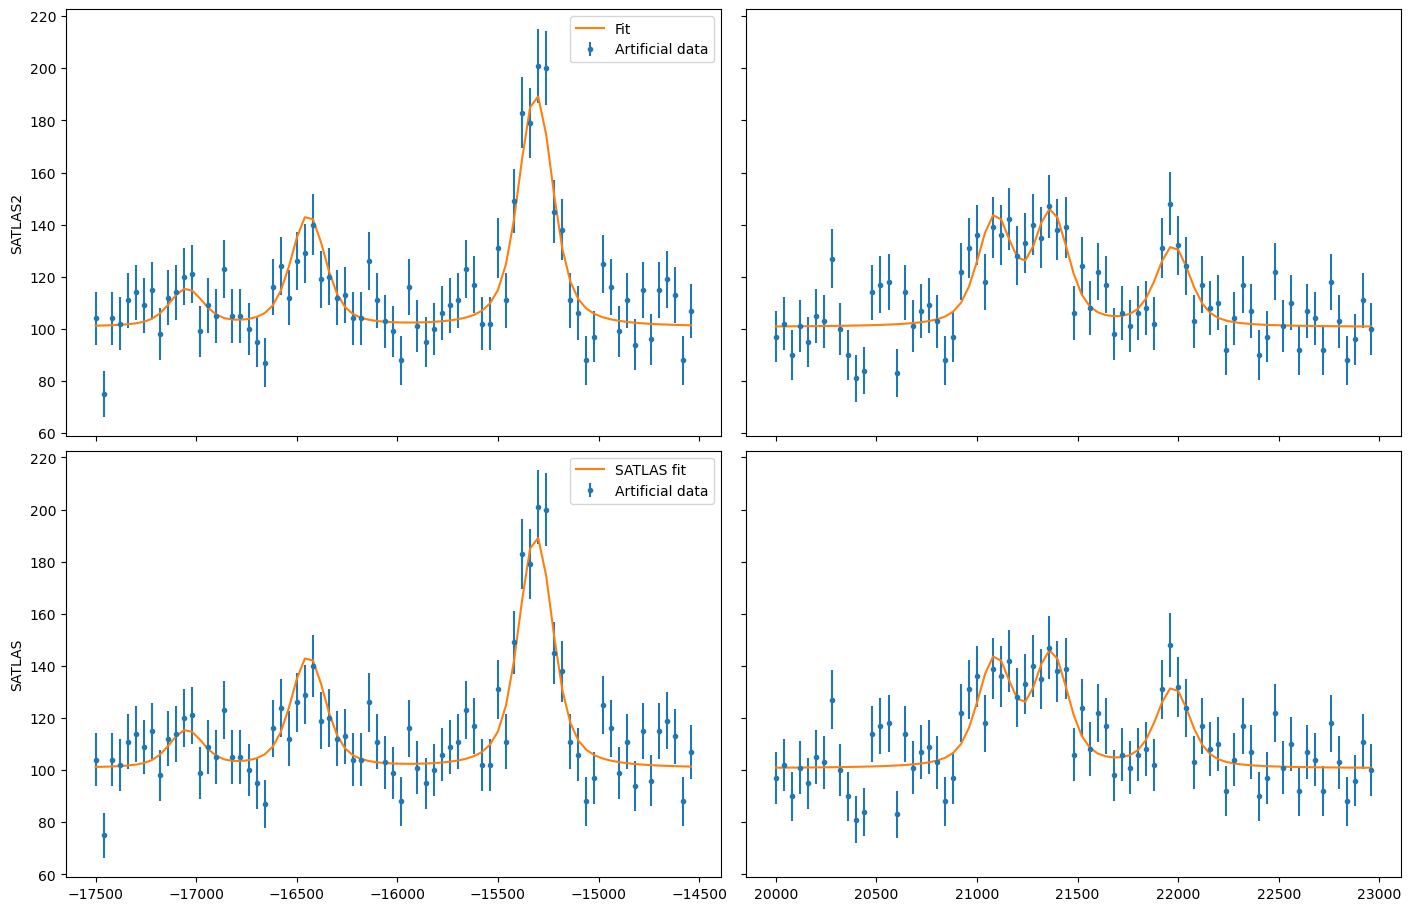

In [5]:
left_x = x[x<0]
right_x = x[x>0]

left_y = y[x<0]
right_y = y[x>0]

fig = plt.figure(constrained_layout=True, figsize=(14, 9))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax11.label_outer()
ax12 = fig.add_subplot(gs[0, 1], sharey=ax11)
ax12.label_outer()
ax21 = fig.add_subplot(gs[1, 0], sharex=ax11)
ax21.label_outer()
ax22 = fig.add_subplot(gs[1, 1], sharex=ax12, sharey=ax21)
ax22.label_outer()

ax11.errorbar(left_x, left_y, modifiedSqrt(left_y), fmt='.', label='Artificial data')
ax11.plot(left_x, hfs(left_x), '-', label='Fit')
ax12.errorbar(right_x, right_y, modifiedSqrt(right_y), fmt='.', label='Artificial data')
ax12.plot(right_x, hfs(right_x), '-', label='Fit')

ax21.errorbar(left_x, left_y, modifiedSqrt(left_y), fmt='.', label='Artificial data')
ax21.plot(left_x, hfs1(left_x), '-', label='SATLAS fit')
ax22.errorbar(right_x, right_y, modifiedSqrt(right_y), fmt='.', label='Artificial data')
ax22.plot(right_x, hfs1(right_x), '-', label='SATLAS fit')

ax11.legend()
ax21.legend()

ax11.set_ylabel('SATLAS2')
ax21.set_ylabel('SATLAS')

plt.show()

# Overlapping hyperfine spectra

The other most common usecase for SATLAS was analysis of spectra with an isomer present, resulting in overlapping spectra. In the SATLAS terminology, this would result in a *SumModel* being used. In SATLAS2, a second *HFS* is simply added to the Source. However, the interface does provide the folllowing functionality:

In [6]:
J = [0.5, 1.5]
FWHMG = 135
FWHML = 101

spin1 = 4
A1 = [5300, 100]
B1 = [0, 230]
C1 = [0, 0]
centroid1 = 400
bkg1 = 60
scale1 = 90

spin2 = 7
A2 = [3300, 60]
B2 = [0, 270]
C2 = [0, 0]
centroid2 = -100
bkg2 = 60
scale2 = 160

x = np.arange(-13000, -9000, 40)
x = np.hstack([x, np.arange(11000, 14000, 40)])
rng = np.random.default_rng(0)

# Interface models
hfs1 = satlas2.HFSModel(I=spin1,
                        J=J,
                        ABC=[A1[0], A1[1], B1[0], B1[1], C1[0], C1[1]],
                        centroid=centroid1,
                        fwhm=[FWHMG, FWHML],
                        scale=scale1,
                        background_params=[bkg1],
                        use_racah=True)
hfs1.set_variation({'Cu': False})
hfs2 = satlas2.HFSModel(I=spin2,
                        J=J,
                        ABC=[A2[0], A2[1], B2[0], B2[1], C2[0], C2[1]],
                        centroid=centroid2,
                        fwhm=[FWHMG, FWHML],
                        scale=scale2,
                        background_params=[bkg2],
                        use_racah=True)
hfs2.set_variation({'Cu': False})
y = hfs1.f(x) + hfs2.f(x) + satlas2.Polynomial([bkg1]).f(x)
y = rng.poisson(y)

hfs1.params['centroid'].value = centroid1 - 100
hfs2.params['centroid'].value = centroid2 - 100
summodel = satlas2.SumModel([hfs1, hfs2], {
    'values': [bkg1, bkg2],
    'bounds': [0]
})

# SATLAS implementation
hfs3 = sat.HFSModel(spin1,
                    J, [A1[0], A1[1], B1[0], B1[1], C1[0], C1[1]],
                    centroid - 100, [FWHMG, FWHML],
                    scale=scale1,
                    background_params=bkg,
                    use_racah=True)
hfs4 = sat.HFSModel(spin2,
                    J, [A2[0], A2[1], B2[0], B2[1], C2[0], C2[1]],
                    centroid - 100, [FWHMG, FWHML],
                    scale=scale2,
                    background_params=[0],
                    use_racah=True)
hfs3.set_variation({'Cu': False})
hfs4.set_variation({'Background0': False, 'Cu': False})
summodel2 = hfs3 + hfs4

print('Fitting 1 dataset with chisquare (Pearson, satlas2)...')
start = time.time()
f = satlas2.chisquare_fit(summodel, x, y, modifiedSqrt(y))
print(summodel.display_chisquare_fit(show_correl=False))
stop = time.time()
dt1 = stop - start
start = time.time()
sat.chisquare_fit(summodel2, x, y, modifiedSqrt(y))
summodel2.display_chisquare_fit(show_correl=False, scaled=True)
stop = time.time()
dt2 = stop - start
print('SATLAS2: {:.3} s'.format(dt1))
print('SATLAS1: {:.3} s'.format(dt2))



Fitting 1 dataset with chisquare (Pearson, satlas2)...
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 291
    # data points      = 175
    # variables        = 16
    chi-square         = 166.792273
    reduced chi-square = 1.04900801
    Akaike info crit   = 23.5935582
    Bayesian info crit = 74.2301338
[[Variables]]
    Fit___HFModel__4___centroid:       421.201657 +/- 6.27607829 (1.49%) (init = 300)
    Fit___HFModel__4___Al:             5313.73380 +/- 4.60447109 (0.09%) (init = 5300)
    Fit___HFModel__4___Au:             105.171460 +/- 1.98883087 (1.89%) (init = 100)
    Fit___HFModel__4___Bl:             0 (fixed)
    Fit___HFModel__4___Bu:             217.091876 +/- 17.0714679 (7.86%) (init = 230)
    Fit___HFModel__4___Cl:             0 (fixed)
    Fit___HFModel__4___Cu:             0 (fixed)
    Fit___HFModel__4___FWHMG:          29.2819035 +/- 125.489386 (428.56%) (init = 135)
    Fit___HFModel__4___FWHML:          161.314301 +/- 33.9739752 (21.

Chisquare fitting in progress (166.79425910209244): 379it [00:10, 33.72it/s]


NDoF: 160, Chisquare: 166.79426, Reduced Chisquare: 1.0424641
Akaike Information Criterium: 21.595642, Bayesian Information Criterium: 69.067432
Errors scaled with reduced chisquare.
[[Variables]]
    s0_FWHMG:          28.9780398 +/- 126.283955 (435.79%) (init = 29.03236)
    s0_FWHML:          161.420258 +/- 33.7741807 (20.92%) (init = 161.4094)
    s0_TotalFWHM:      166.815855 +/- 22.1430745 (13.27%) == '0.5346*s0_FWHML+(0.2166*s0_FWHML**2+s0_FWHMG**2)**0.5'
    s0_Scale:          93.5945060 +/- 7.98622420 (8.53%) (init = 93.59192)
    s0_Saturation:     0 (fixed)
    s0_Amp7_2__5_2:    0.5000937 (fixed)
    s0_Amp7_2__7_2:    0.4939217 (fixed)
    s0_Amp7_2__9_2:    0.3396039 (fixed)
    s0_Amp9_2__7_2:    0.172911 (fixed)
    s0_Amp9_2__9_2:    0.4939521 (fixed)
    s0_Amp9_2__11_2:   1 (fixed)
    s0_Al:             5313.73024 +/- 4.58833543 (0.09%) (init = 5313.729)
    s0_Au:             105.169451 +/- 1.98179869 (1.88%) (init = 105.1687)
    s0_Bl:             0 (fixed)
    s

The difference in coding implementation is a result of the interface automatically implementing a Step background, where the background is a constant for different regions in *x*-space. Notice here that the speedup due using the SATLAS2 implementation has risen from a factor 20 for a single spectrum to almost a factor 100.

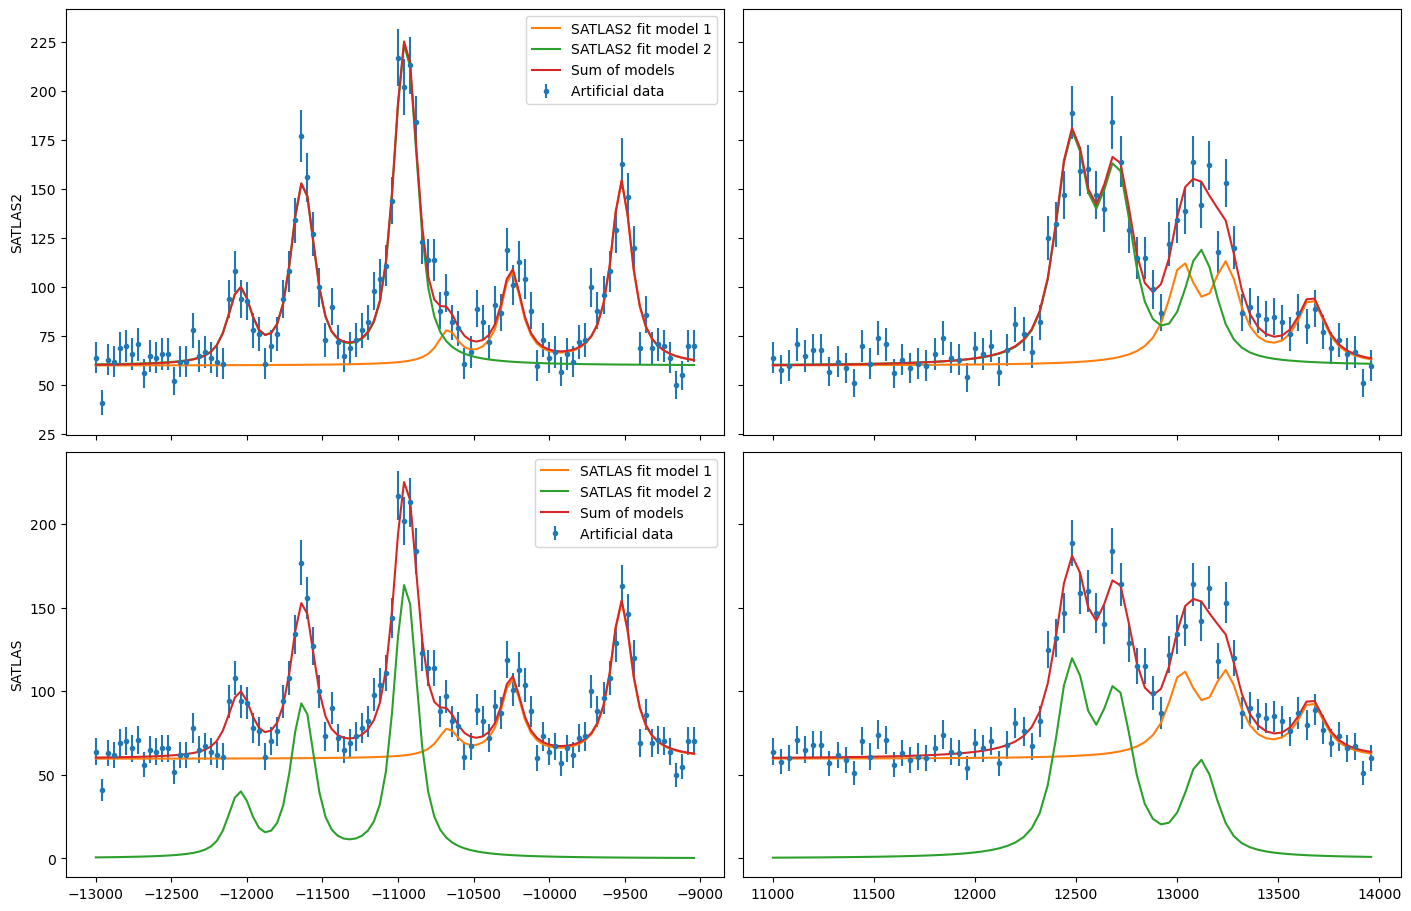

In [7]:
left_x = x[x<0]
right_x = x[x>0]

left_y = y[x<0]
right_y = y[x>0]

fig = plt.figure(constrained_layout=True, figsize=(14, 9))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax11.label_outer()
ax12 = fig.add_subplot(gs[0, 1], sharey=ax11)
ax12.label_outer()
ax21 = fig.add_subplot(gs[1, 0], sharex=ax11)
ax21.label_outer()
ax22 = fig.add_subplot(gs[1, 1], sharex=ax12, sharey=ax21)
ax22.label_outer()

ax11.errorbar(left_x, left_y, modifiedSqrt(left_y), fmt='.', label='Artificial data')
ax11.plot(left_x, hfs1(left_x), '-', label='SATLAS2 fit model 1')
ax11.plot(left_x, hfs2(left_x), '-', label='SATLAS2 fit model 2')
ax11.plot(left_x, summodel(left_x), '-', label='Sum of models')

ax12.errorbar(right_x, right_y, modifiedSqrt(right_y), fmt='.', label='Artificial data')
ax12.plot(right_x, hfs1(right_x), '-', label='SATLAS2 fit model 1')
ax12.plot(right_x, hfs2(right_x), '-', label='SATLAS2 fit model 2')
ax12.plot(right_x, summodel(right_x), '-', label='Sum of models')
ax11.legend()

ax21.errorbar(left_x, left_y, modifiedSqrt(left_y), fmt='.', label='Artificial data')
ax21.plot(left_x, hfs3(left_x), '-', label='SATLAS fit model 1')
ax21.plot(left_x, hfs4(left_x), '-', label='SATLAS fit model 2')
ax21.plot(left_x, summodel2(left_x), '-', label='Sum of models')

ax22.errorbar(right_x, right_y, modifiedSqrt(right_y), fmt='.', label='Artificial data')
ax22.plot(right_x, hfs3(right_x), '-', label='SATLAS fit model 1')
ax22.plot(right_x, hfs4(right_x), '-', label='SATLAS fit model 2')
ax22.plot(right_x, summodel2(right_x), '-', label='Sum of models')
ax21.legend()

ax11.set_ylabel('SATLAS2')
ax21.set_ylabel('SATLAS')
plt.show()

# Different background for multiplets

To demonstrate the convenience of the Step background, the same results are coded with SATLAS, where the use of LinkedModel is required. Note that here, the interface is *not* used.

In [8]:
J = [0.5, 1.5]
FWHMG = 135
FWHML = 101

spin1 = 4
A1 = [5300, 100]
B1 = [0, 230]
C1 = [0, 0]
centroid1 = 400
bkg1 = 90
scale1 = 90

x = np.arange(-13000, -9000, 40)
x = np.hstack([x, np.arange(11000, 14000, 40)])
rng = np.random.default_rng(0)

hfs = satlas2.HFS(spin1,
                   J=J,
                   A=[A1[0], A1[1]],
                   B=[B1[0], B1[1]],
                   C=[C1[0], C1[1]],
                   df=centroid1,
                   fwhmg=FWHMG,
                   fwhml=FWHML,
                   scale=scale1,
                   racah=True
                  )
hfs.params['Cu'].vary = False
bkg = satlas2.Step([bkg1, bkg2], [0])

y = hfs1.f(x) + bkg.f(x)
y = rng.poisson(y)

s = satlas2.Source(x, y, yerr=modifiedSqrt, name='Artificial')
s.addModel(hfs)
s.addModel(bkg)
f = satlas2.Fitter()
f.addSource(s)

hfs2 = sat.HFSModel(spin1,
                    J, [A1[0], A1[1], B1[0], B1[1], C1[0], C1[1]],
                    centroid - 100, [FWHMG, FWHML],
                    scale=scale1,
                    background_params=[bkg1],
                    use_racah=True)
hfs3 = sat.HFSModel(spin1,
                    J, [A1[0], A1[1], B1[0], B1[1], C1[0], C1[1]],
                    centroid - 100, [FWHMG, FWHML],
                    scale=scale1,
                    background_params=[bkg1],
                    use_racah=True)
hfs2.set_variation({'Cu': False})
hfs3.set_variation({'Cu': False})
linkedmodel = sat.LinkedModel([hfs2, hfs3])
linkedmodel.shared = ['Al', 'Au', 'Bl', 'Bu', 'Centroid']
linked_x = [x[x<0], x[x>0]]
linked_y = [y[x<0], y[x>0]]

print('Fitting 1 dataset with chisquare (Pearson, satlas2)...')
start = time.time()
f.fit()
stop = time.time()
print(f.reportFit())
dt1 = stop - start
start = time.time()
sat.chisquare_spectroscopic_fit(linkedmodel, linked_x, linked_y, func=modifiedSqrt)
stop = time.time()
linkedmodel.display_chisquare_fit(show_correl=False, scaled=True)
dt2 = stop - start
print('SATLAS2: {:.3} s'.format(dt1))
print('SATLAS1: {:.3} s'.format(dt2))

Fitting 1 dataset with chisquare (Pearson, satlas2)...
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 167
    # data points      = 175
    # variables        = 9
    chi-square         = 170.061971
    reduced chi-square = 1.02446971
    Akaike info crit   = 12.9909634
    Bayesian info crit = 41.4740372
[[Variables]]
    Artificial___HFS___centroid:      428.657492 +/- 7.19104252 (1.68%) (init = 400)
    Artificial___HFS___Al:            5308.21780 +/- 5.60047942 (0.11%) (init = 5300)
    Artificial___HFS___Au:            104.430048 +/- 2.30813893 (2.21%) (init = 100)
    Artificial___HFS___Bl:            0 (fixed)
    Artificial___HFS___Bu:            265.552916 +/- 19.1450076 (7.21%) (init = 230)
    Artificial___HFS___Cl:            0 (fixed)
    Artificial___HFS___Cu:            0 (fixed)
    Artificial___HFS___FWHMG:         0.01009164 +/- 457.863719 (4537058.84%) (init = 135)
    Artificial___HFS___FWHML:         179.647033 +/- 18.3401608 (10.21%) (

Chisquare fitting done: 361it [00:10, 33.53it/s]                            


NDoF: 163, Chisquare: 169.0098, Reduced Chisquare: 1.0368699
Akaike Information Criterium: 17.904873, Bayesian Information Criterium: 55.882305
Errors scaled with reduced chisquare.
[[Variables]]
    s0_FWHMG:         1.00200757 +/- 5039.81586 (502971.83%) (init = 1.002008)
    s0_FWHML:         190.625875 +/- 44.2918367 (23.23%) (init = 190.6259)
    s0_TotalFWHM:     190.632114 +/- 31.1034805 (16.32%) == '0.5346*s0_FWHML+(0.2166*s0_FWHML**2+s0_FWHMG**2)**0.5'
    s0_Scale:         86.9765425 +/- 10.6152858 (12.20%) (init = 86.97654)
    s0_Saturation:    0 (fixed)
    s0_Amp7_2__5_2:   0.5000937 (fixed)
    s0_Amp7_2__7_2:   0.4939217 (fixed)
    s0_Amp7_2__9_2:   0.3396039 (fixed)
    s0_Amp9_2__7_2:   0.172911 (fixed)
    s0_Amp9_2__9_2:   0.4939521 (fixed)
    s0_Amp9_2__11_2:  1 (fixed)
    s0_Al:            5308.26995 +/- 5.39979300 (0.10%) (init = 5308.27)
    s0_Au:            104.153329 +/- 2.24981898 (2.16%) (init = 104.1533)
    s0_Bl:            0 (fixed)
    s0_Bu:       

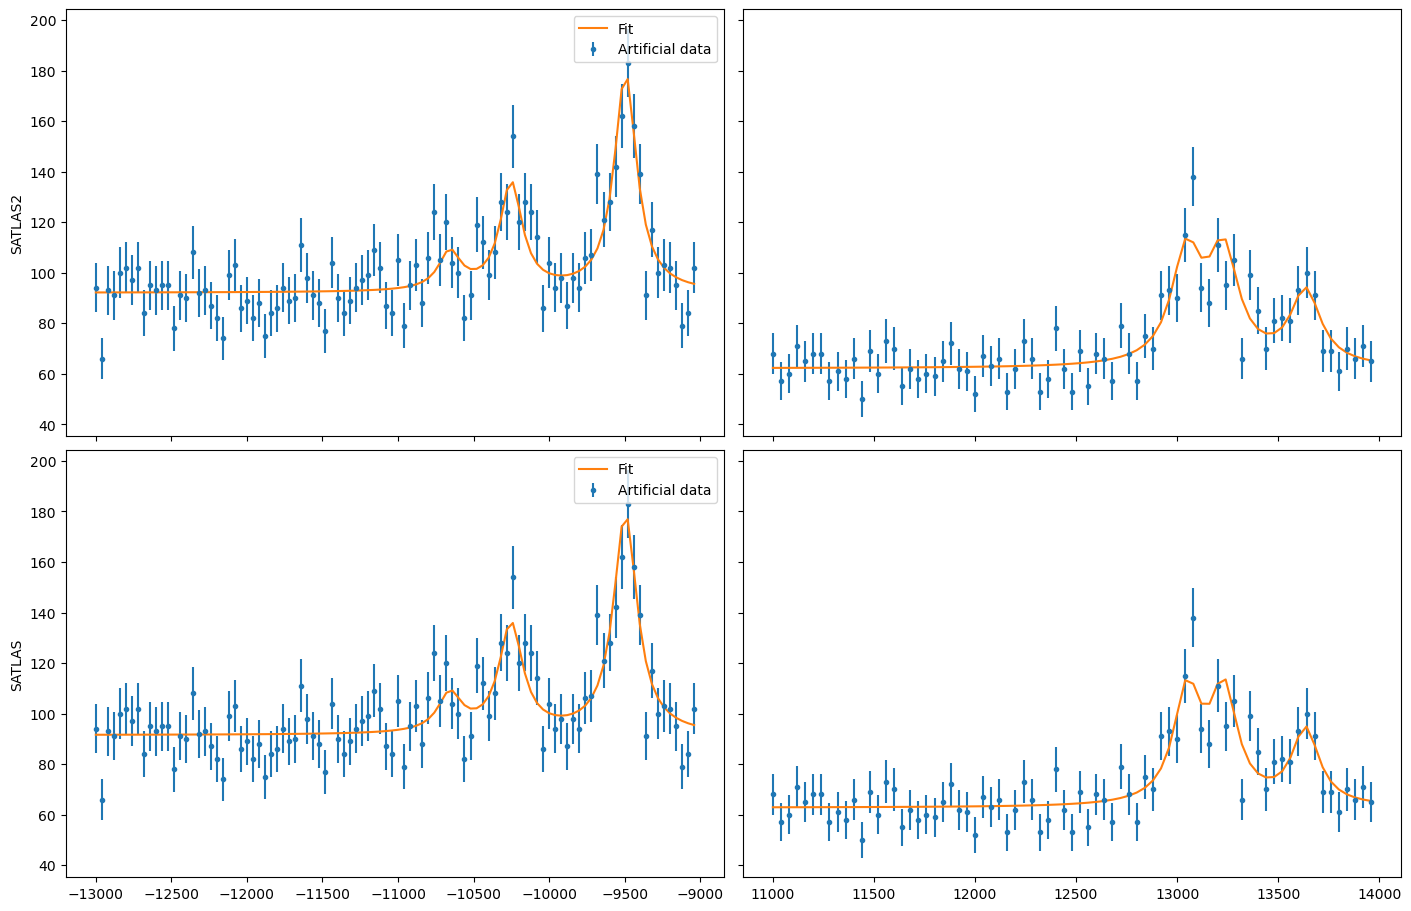

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(14, 9))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax11.label_outer()
ax12 = fig.add_subplot(gs[0, 1], sharey=ax11)
ax12.label_outer()
ax21 = fig.add_subplot(gs[1, 0], sharex=ax11)
ax21.label_outer()
ax22 = fig.add_subplot(gs[1, 1], sharex=ax12, sharey=ax21)
ax22.label_outer()

ax11.errorbar(linked_x[0], linked_y[0], modifiedSqrt(linked_y[0]), fmt='.', label='Artificial data')
ax11.plot(linked_x[0], s.evaluate(linked_x[0]), '-', label='Fit')
ax12.errorbar(linked_x[1], linked_y[1], modifiedSqrt(linked_y[1]), fmt='.', label='Artificial data')
ax12.plot(linked_x[1], s.evaluate(linked_x[1]), '-', label='SATLAS2 fit model 1')
ax11.legend()

ax21.errorbar(linked_x[0], linked_y[0], modifiedSqrt(linked_y[0]), fmt='.', label='Artificial data')
ax21.plot(linked_x[0], linkedmodel.models[0](linked_x[0]), '-', label='Fit')
ax22.errorbar(linked_x[1], linked_y[1], modifiedSqrt(linked_y[1]), fmt='.', label='Artificial data')
ax22.plot(linked_x[1], linkedmodel.models[1](linked_x[1]), '-', label='Fit')
ax21.legend()

ax11.set_ylabel('SATLAS2')
ax21.set_ylabel('SATLAS')
plt.show()